# Transverse Field Ising Model example

In the following example we will run the dmrg code for an Ising model for a single point in parameter space

## Create the MPO

The first key element for the DMRG simulation is the MPO. In order to read by the dmrg software it needs to be defined as class, but before let's look at how we want to write its methods. The Hamiltonian we want to write is the following:
$$ H = -J\sum_{\langle i,j \rangle} \sigma_i^z \sigma_j^z -h_x\sum_i \sigma_i^x

### Left MPO

The left tensor will be written as a function with the following name

In [156]:
def Wl(J,h_x):

    # Define as empty tensor
    Wleft = np.zeros((2,2,3))

    # Define the spin operators
    Id = np.identity(2)
    Z = np.array([[1,0],[0,-1]])
    X = np.array([[0,1],[1,0]])

    # Fill the interactions
    Wleft[:,:,0] = MPO_TFI.Id
    Wleft[:,:,1] = -J*MPO_TFI.Z
    Wleft[:,:,2] = -h_x*MPO_TFI.X

    return Wleft

### Bulk MPO

In [157]:

def mpo(J,h_x,p=None):
    
    # Define as empty tensor
    MPO = np.zeros((2,2,3,3))

    # Define the spin operators
    Id = np.identity(2)
    Z = np.array([[1,0],[0,-1]])
    X = np.array([[0,1],[1,0]])

    # Fill the interactions
    MPO[:,:,0,0] = MPO_TFI.Id
    
    MPO[:,:,0,1] = -J* MPO_TFI.Z
    MPO[:,:,0,2] = -h_x*MPO_TFI.X

    MPO[:,:,1,2] = MPO_TFI.Z
    MPO[:,:,2,2] = MPO_TFI.Id 

    return MPO

### Right MPO

In [158]:
def Wr(J,h_x):

    # Define an empty tensor
    Wright = np.zeros((2,2,3))

    # Define the spin operators
    Id = np.identity(2)
    Z = np.array([[1,0],[0,-1]])
    X = np.array([[0,1],[1,0]])

    # Fill the interactions
    Wright[:,:,0] = -h_x*MPO_TFI.X
    Wright[:,:,1] = MPO_TFI.Z 
    Wright[:,:,2] = MPO_TFI.Id 

    return Wright

### Create the simplest class

The functions alone will not be read by the software, in order to use it we need to create a class and add the previous functions as its methods

In [159]:
import numpy as np
class MPO_TFI():

    # Define the class variables
    Id = np.identity(2)
    Z = np.array([[1,0],[0,-1]])
    X = np.array([[0,1],[1,0]])

    # Define the class attributes (The couplings of the Hamitonian)
    def __init__(self,J,h_x):
        self.J = J 
        self.h_x = h_x


    def Wl(self):
        
        # Define an empty tensor
        Wleft = np.zeros((2,2,3))

        # Fill in the interactions
        Wleft[:,:,0] = MPO_TFI.Id
        Wleft[:,:,1] = -self.J*MPO_TFI.Z
        Wleft[:,:,2] = -self.h_x*MPO_TFI.X

        return Wleft


    def mpo(self,p=None):

        # Define an empty tensor
        MPO = np.zeros((2,2,3,3))

        # Fill in the interactions
        MPO[:,:,0,0] = MPO_TFI.Id
        
        MPO[:,:,0,1] = -self.J* MPO_TFI.Z
        MPO[:,:,0,2] = -self.h_x*MPO_TFI.X

        MPO[:,:,1,2] = MPO_TFI.Z
        MPO[:,:,2,2] = MPO_TFI.Id 

        return MPO


    def Wr(self):

        # Define an emtpy tensor
        Wright = np.zeros((2,2,3))

        # Fill in the interactions
        Wright[:,:,0] = -self.h_x*MPO_TFI.X
        Wright[:,:,1] = MPO_TFI.Z 
        Wright[:,:,2] = MPO_TFI.Id 

        return Wright

### Add the polarization on the boundary

In a lot of circumstances the dmrg simulation will need to be run with a given polarization on the boundary. Here is an example of how we can include it into our MPO_TFI class.

In [160]:
class MPO_TFI():

    # Define the class variables
    Id = np.identity(2)
    Z = np.array([[1,0],[0,-1]])
    X = np.array([[0,1],[1,0]])
    d = 2

    # Define the class attributes (The couplings of the Hamitonian and boundary polarization)
    def __init__(self,J,h_x,pol=None,d=2):
        self.J = J 
        self.h_x = h_x 
        self.pol = pol


    def Wl(self):

        # Define an empty tensor
        Wleft = np.zeros((2,2,3))

        # Fill in the interactions
        Wleft[:,:,0] = MPO_TFI.Id
        Wleft[:,:,1] = -self.J*MPO_TFI.Z
        Wleft[:,:,2] = -self.h_x*MPO_TFI.X

        # Add polarization term
        if self.pol == 'tot':
            Wleft[:,:,2] -= 10*MPO_TFI.Z

        return Wleft


    def mpo(self,p=None):

        # Define an empty tensor
        MPO = np.zeros((2,2,3,3))

        # Fill in the interactions
        MPO[:,:,0,0] = MPO_TFI.Id
        
        MPO[:,:,0,1] = -self.J* MPO_TFI.Z
        MPO[:,:,0,2] = -self.h_x*MPO_TFI.X

        MPO[:,:,1,2] = MPO_TFI.Z
        MPO[:,:,2,2] = MPO_TFI.Id 

        return MPO


    def Wr(self):

        # Define an empty tensor
        Wright = np.zeros((2,2,3))

        # Fill in the interactions
        Wright[:,:,0] = -self.h_x*MPO_TFI.X
        Wright[:,:,1] = MPO_TFI.Z 
        Wright[:,:,2] = MPO_TFI.Id 

        # Add polarizations term
        if self.pol == 'tot':
            Wright[:,:,0] -= 10*MPO_TFI.Z

        return Wright

Now the MPO class is ready to be used in our simulation

### Run a single point in parameter space

First we need to initialize the MPS. We can decide where we want to store the tensors, if nothing is specified a folder named MPS will be created in the same folder where we are running our code.

In [161]:
# import the MPS class from dmrg
from dmrg.MPS import MPS 

# specify the number of sites on the chain
L = 20 

# initialise the MPS for the indicated chain length
mps = MPS(L)

# check the location of the tensors
print('MPS path:',mps.path)

MPS path: MPS


Then we need to define the MPO and the contractions. The contractions behave similarly to the MPS, if the path is not specified a folder named CONT will be created in the same folder where we are running our code.

In [162]:
# import the CONT class from dmrg
from dmrg.cont import CONT

# define the MPO 
h = MPO_TFI(J=1,h_x=1,pol='tot')

# We can check the polarization of the Hamiltonian
print('H polarization:',h.pol)

# define the contractions (it needs an mps and a MPO class as imputs)
cont = CONT(mps=mps,H=h)

# check the location of the tensors
print('CONT path:',cont.path) 

H polarization: tot
CONT path: CONT


Now we need to initialize the dmrg

In [163]:
# import the dmrg class from dmrg
from dmrg.dmrg import dmrg

# Initialize your dmrg
sys = dmrg(cont=cont,chi=100,cut=1e-12)

# Check maximum bond dimension
print('Max bond dimension:',sys.chi)

# Check singular value cut off
print('Singular value cut off:',sys.cut)


Max bond dimension: 100
Singular value cut off: 1e-12


Now that the dmrg is ready we can start the calculation. First we need to grow the system to the desired dimension (L). Afterwards we can start sweeping along all the sites.

In [ ]:
# Set low bond dimension to grow the system faster
sys.chi = 4

# Grow the system up to the desired dimension
En = sys.infinite()

# En stores all the energies found while growing the system
print(En)

# Increase the bond dimension for the sweeping
sys.chi = 100

# Store energy values
E_sweep = []

# The system has grown from the middle so first we need to do a sweep and a half
for site,dir in mps.first_sweep():
    E,S = sys.step2sites(site,dir=dir)
    E_sweep.append(E)

# Set up counter and energy check
k = 0 
En_temp = np.zeros(2*L-8)
En_temp[0] = E

# Now we can sweep the system  (ideally until convergence)
while np.abs(En_temp[0] - En_temp[-1]) > 1e-10:
    j = 0
    for site,dir in mps.sweep():
        E,S = sys.step2sites(site,dir=dir)
        En_temp[j] = E
        E_sweep.append(E)
        j +=1

    # set maximum number of sweeps
    if k > 5:
        break
    
    k += 1

[-23.58593739 -26.11878607 -28.65892495 -31.20173587 -33.74582239
 -36.29061651 -38.83584339 -41.38135379 -43.92705964]


Now we can check if the system has actually converged

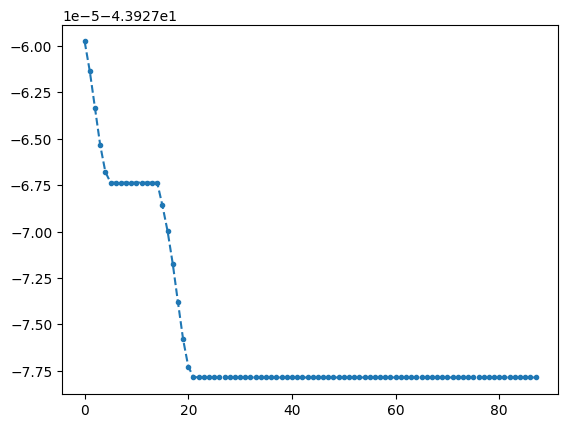

In [ ]:
# Import matplotlib to plot
import matplotlib.pyplot as plt

# Plot Energy along the sweep
plt.plot(E_sweep,'.--')

Now we can collect the observables we are interested in like local magnetization $\langle \sigma^z\rangle$ and entanglement entropy $S = - \mathrm{Tr}( \rho \log(\rho))$

In [ ]:
# import the observables class
from dmrg.obs import observables

# define observables
obs = observables(mps)

# Initialize empty array
Zobs = np.zeros((2,L))
Sobs = np.zeros((2,L-4))


# sweep the system without updating and collect observables
k = 0
for site,dir in mps.right_sweep():
    En,s = sys.step2sites(site,dir=dir,stage='Final')

    # Collect singular valube
    Sobs[0,k] = site 
    Sobs[1,k] = s

    # Collect local magnetization
    if site == 2:
        o1,o2 = obs.bound_left(site-1,h.Z)
        Zobs[0,0] = 0
        Zobs[0,1] = 1
        Zobs[1,0] = o1.real
        Zobs[1,1] = o2.real 

    Zobs[0,site] = site 
    Zobs[1,site] = obs.single_site(site,h.Z).real
    
    if site == L-3:
        o1,o2 = obs.bound_right(site+1,h.Z)
        Zobs[0,L-2] = L-2
        Zobs[0,L-1] = L-1
        Zobs[1,L-2] = o1.real
        Zobs[1,L-1] = o2.real
    
    k +=1

# left sweep (otional)
for site,dir in mps.left_sweep():
    En,s = sys.step2sites(site,dir=dir,stage='Final')

To collect the two point functions eg. $\langle \sigma^z_i \sigma_j^z\rangle$  we need to use the specific method of the observables class

In [ ]:
# specify where you want to save the correlations 
path_out = 'OUT/ZZ.txt'

# run a right sweep and collect all the correlations 
for site,dir in mps.right_sweep():
    En,s = sys.step2sites(site,dir=dir,stage='Final')

    # The string must be always specified, depending on your model, if only obs1 is specified then obs2 = obs1
    obs.all_corr(path_out,site,string=h.Id,obs1=h.Z,obs2=h.Z)

### Plot the Data

Text(0, 0.5, '$\\langle \\sigma^z\\rangle$')

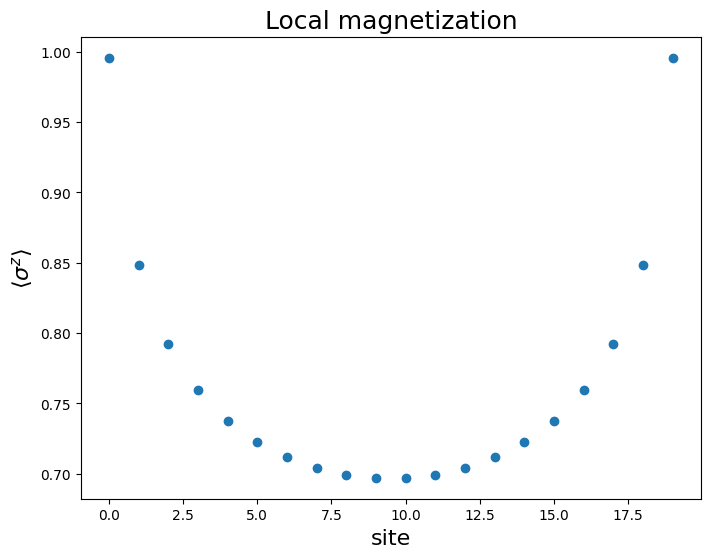

In [ ]:
# Plot the local magnetization
fig,ax = plt.subplots(figsize=(8,6))
ax.plot(Zobs[0],Zobs[1],'o')

ax.set_title('Local magnetization',fontsize=18)
ax.set_xlabel('site',fontsize=16)
ax.set_ylabel(r'$\langle \sigma^z\rangle$',fontsize=16)

Text(0, 0.5, '$S$')

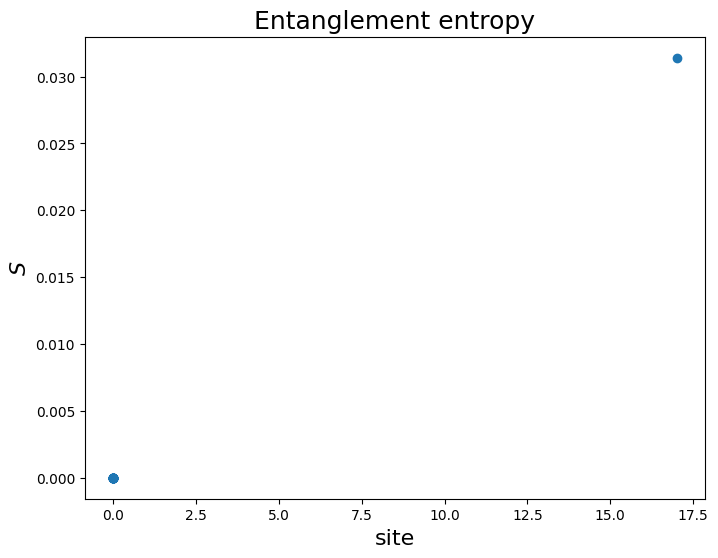

In [ ]:
# Plot the entanglement entropy
fig,ax = plt.subplots(figsize=(8,6))
ax.plot(Sobs[0],Sobs[1],'o')

ax.set_title('Entanglement entropy',fontsize=18)
ax.set_xlabel('site',fontsize=16)
ax.set_ylabel(r'$S$',fontsize=16)

Text(0, 0.5, '$\\langle \\sigma^z_i \\sigma_j^z\\rangle$ ')

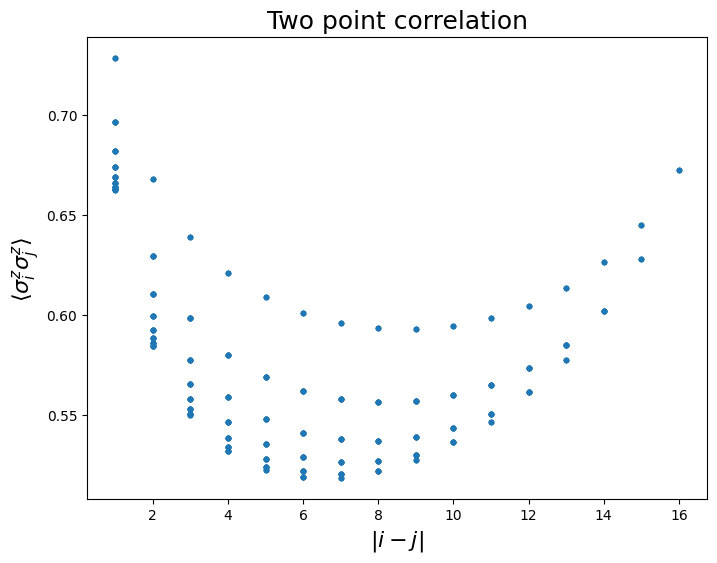

In [ ]:
# Extract the correlation
ZZcorr = np.loadtxt(path_out)

# Plot the correlation 
fig,ax = plt.subplots(figsize=(8,6))
ax.plot(ZZcorr[:,1]- ZZcorr[:,0],ZZcorr[:,2],'.')

ax.set_title('Two point correlation',fontsize=18)
ax.set_xlabel(r'$|i-j|$',fontsize=16)
ax.set_ylabel(r'$\langle \sigma^z_i \sigma_j^z\rangle$ ',fontsize=16)

### Run multiple points

In [ ]:
L = 20
mps = MPS(L)
h = MPO_TFI(1,.1,pol='tot')
cont = CONT(mps,h) 
sys = dmrg(cont,chi=2)
obs = observables(mps)
En0 = sys.infinite()
sys.chi = 100
print(sys.chi)
EE = []
EE.append(En0[-1])
EE_pre = []
k = 0 
print(En0)

for site,dir in mps.first_sweep():
    En,_ = sys.step2sites(site,dir=dir)
    EE.append(E)

for site,dir in mps.sweep():
    En,_ = sys.step2sites(site,dir=dir)
    EE.append(E)

for i in range(2,L-2):
    En_fin,_ =sys.step2sites(i,dir='r',stage='Final')
    EE.append(E)
    
    k += 1
    if i ==L//2:
        Z = obs.single_site(i,h.Z)

100
[-23.00590919 -25.01091232 -27.01591545 -29.02091859 -31.02592172
 -33.03092485 -35.03592798 -37.04093112 -39.04593425]
